# Sixt Data Science Lab - Test Task for Data Scientist Job Candidates

## Introduction

In this test task you will have an opportunity to demonstrate your skills of a Data Scientist from various angles - processing data, analyzing and vizalizing it, finding insights, applying predictive techniques and explaining your reasoning about it.

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

Please go through the steps below, build up the necessary code and comment on your choices.

## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze command should be included as part of your submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset .
3. Load the data into Python runtime as Pandas dataframe.
4. Split the data into two parts. One dataset containing the last 30 days and one dataset with the rest. You will need the dataset with the last 30 days in part 5  

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RepeatedKFold

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
sns.set(style='darkgrid')

In [2]:
# load data
day_data = pd.read_csv('day.csv')

In [3]:
day_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.34,0.36,0.81,0.16,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.36,0.35,0.70,0.25,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.20,0.19,0.44,0.25,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.20,0.21,0.59,0.16,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.23,0.23,0.44,0.19,82,1518,1600


In [4]:
# drop instant column, as it's just an index
day_data.drop(columns='instant', inplace=True)

In [5]:
# inspect data types
day_data.dtypes

dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
# convert dates to datetime objects
day_data['dteday'] = pd.to_datetime(day_data['dteday'])

In [7]:
# confirm there are no duplicated dates
day_data.groupby('dteday')['cnt'].count().max()

1

In [81]:
# check for nulls
day_data.isnull().values.any()

False

In [8]:
# ensure data is sorted by date
day_data.sort_values(by=['dteday'], inplace=True)

In [9]:
# split data sets
train = day_data[:-30].copy()
test = day_data[-30:].copy()

**Answers / comments / reasoning:**

For this section, I loaded the daily data set, as it appears that the requests below are asking for daily numbers. I loaded the data, checked for duplicates and nulls, then sorted it. I finished off with splitting into two data sets as requested.

## Part 2 - Data Processing and Analysis

**Tasks:**
1. Perform all needed steps to load and clean the data. Please comment the major steps of your code.
2. Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Find the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Vizalize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)


In [10]:
# have a look at summary stats
train.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,701.00,701.00,701.00,701.00,701.00,701.00,701.00,701.00,701.00,701.00,701.00,701.00,701.00,701.00
mean,2.48,0.48,6.29,0.03,3.00,0.68,1.39,0.50,0.48,0.63,0.19,866.94,"3,661.10","4,528.04"
std,1.09,0.50,3.33,0.17,2.00,0.46,0.54,0.18,0.16,0.14,0.08,693.47,"1,553.47","1,939.77"
min,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.06,0.08,0.00,0.02,2.00,20.00,22.00
25%,2.00,0.00,3.00,0.00,1.00,0.00,1.00,0.34,0.35,0.52,0.13,317.00,"2,507.00","3,194.00"
50%,2.00,0.00,6.00,0.00,3.00,1.00,1.00,0.51,0.50,0.62,0.18,738.00,"3,656.00","4,541.00"
75%,3.00,1.00,9.00,0.00,5.00,1.00,2.00,0.66,0.61,0.73,0.23,"1,135.00","4,739.00","6,041.00"
max,4.00,1.00,12.00,1.00,6.00,1.00,3.00,0.86,0.84,0.97,0.51,"3,410.00","6,946.00","8,714.00"


<AxesSubplot:xlabel='cnt'>

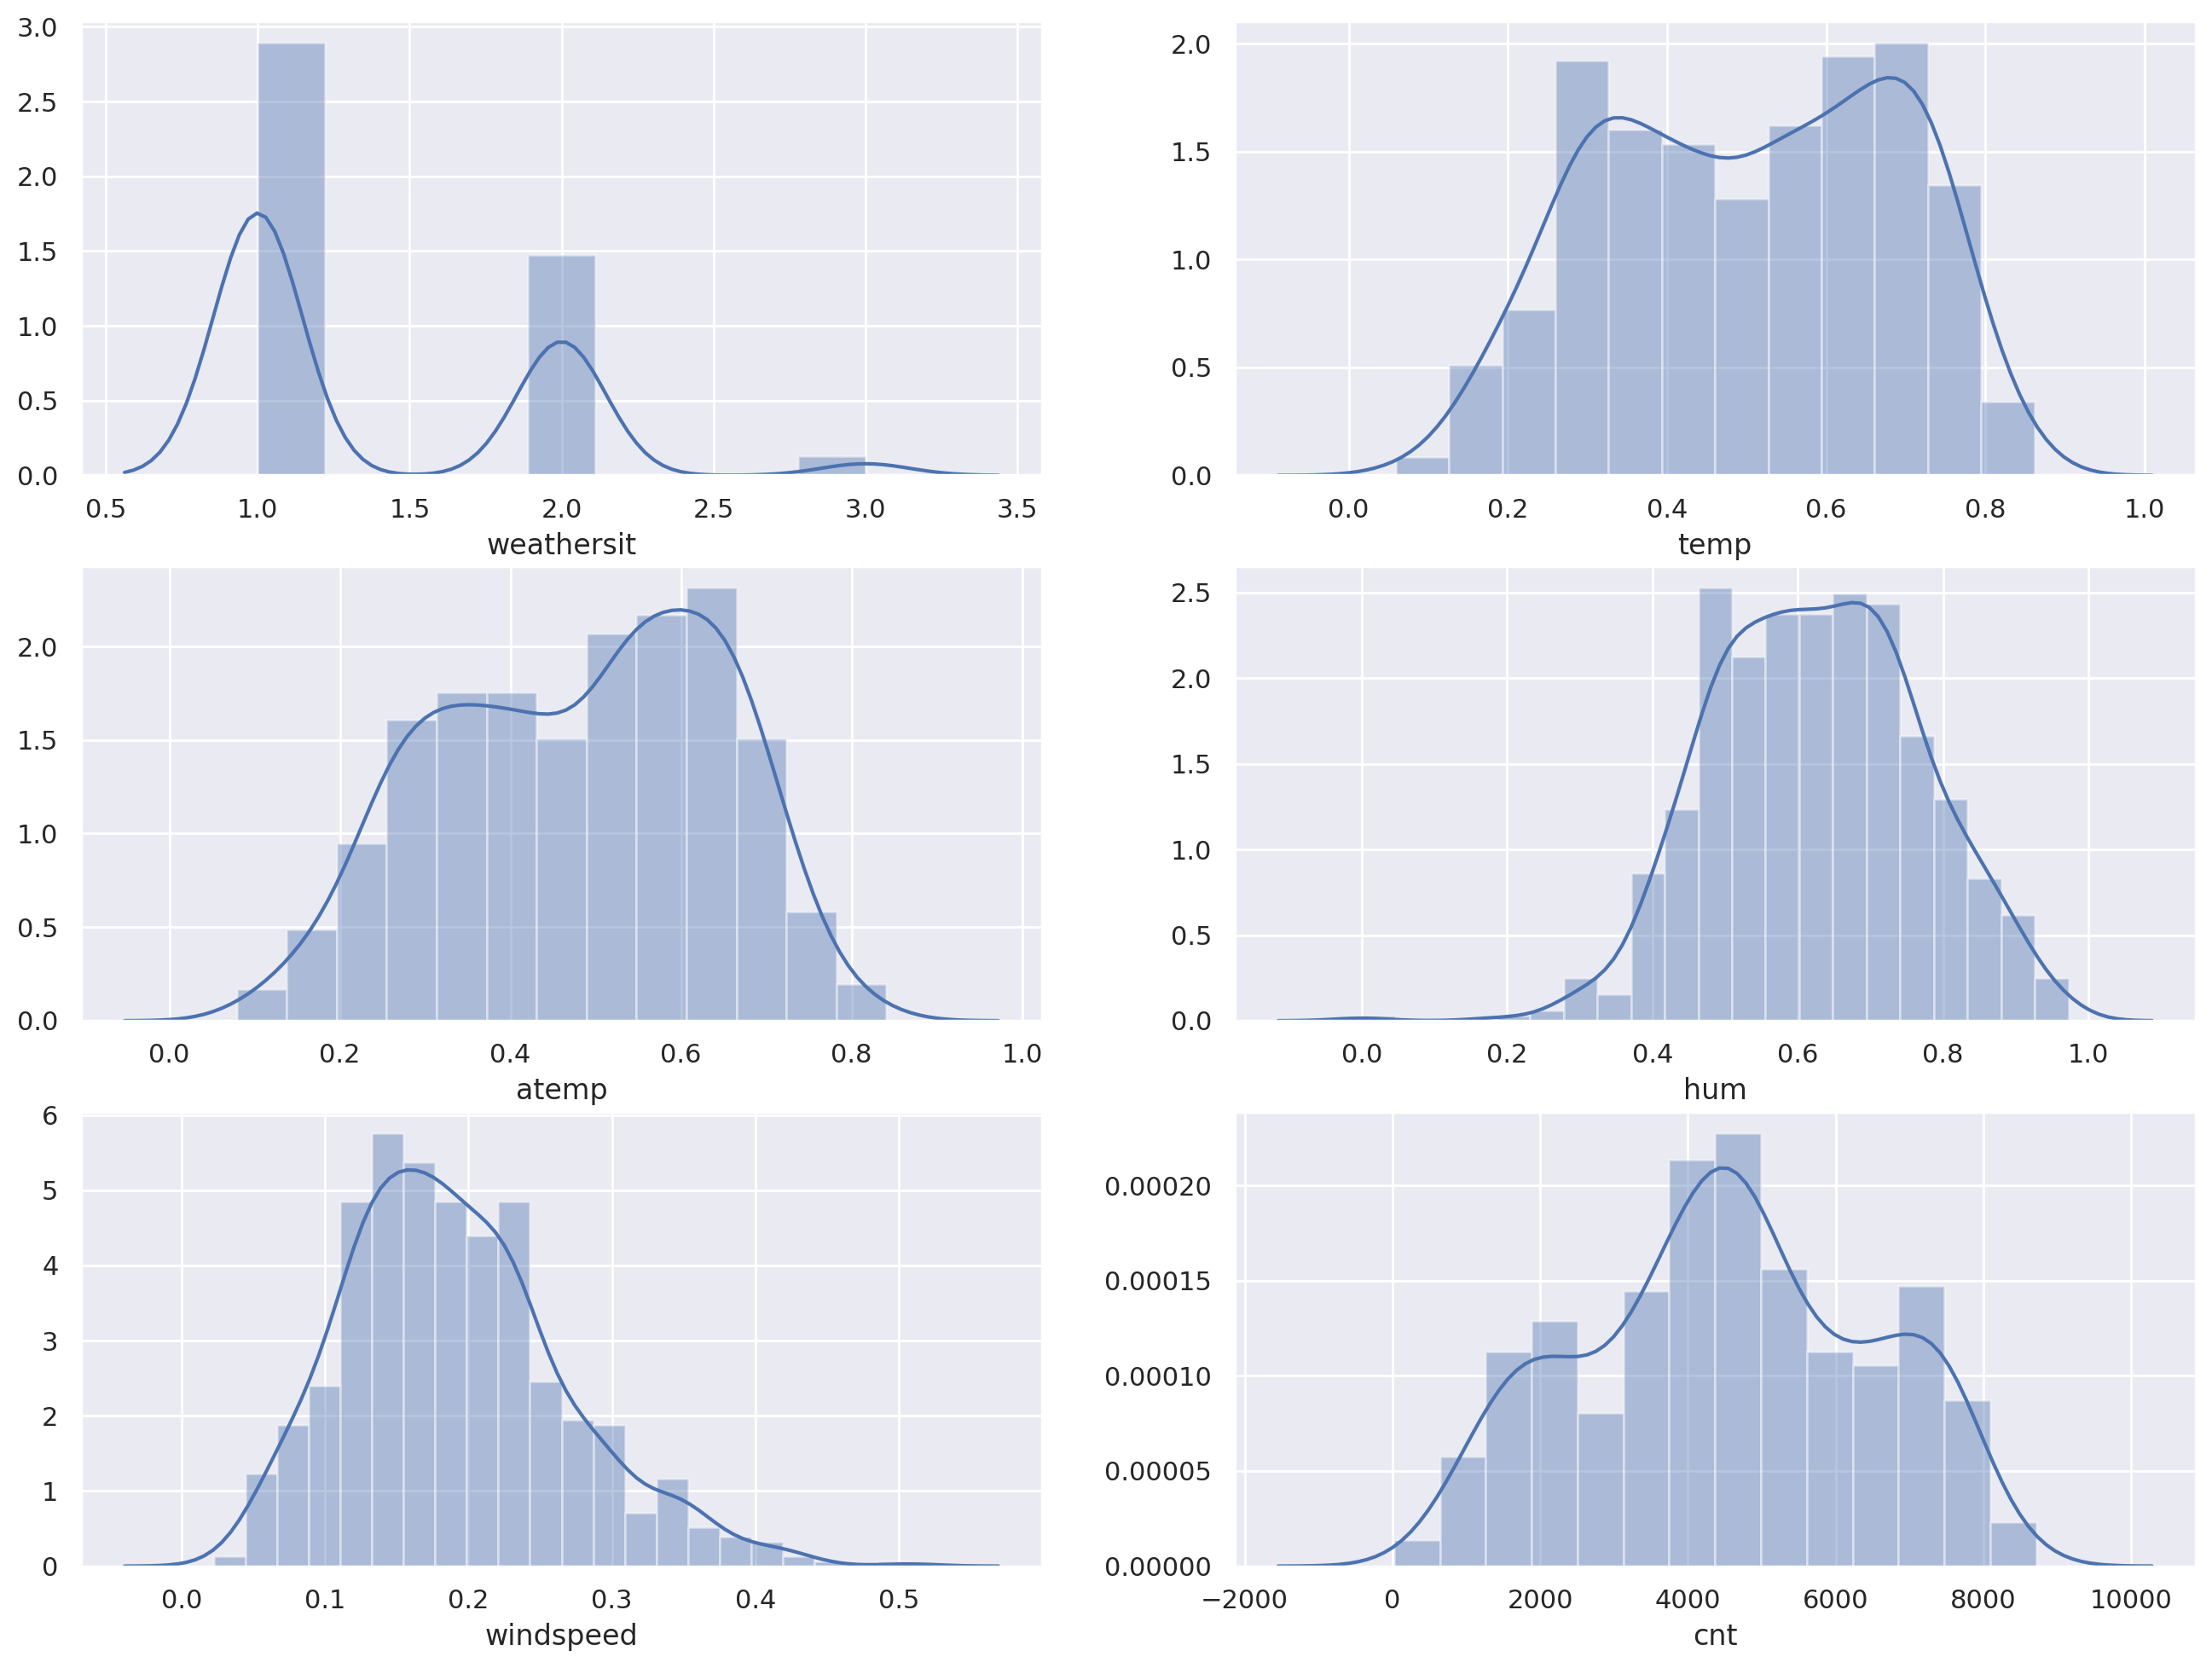

In [11]:
# visualize the distributions of numerical features

f, axes = plt.subplots(3, 2, figsize=(16,12), dpi=200)

sns.distplot(train['weathersit'], ax=axes[0, 0])
sns.distplot(train['temp'], ax=axes[0, 1])
sns.distplot(train['atemp'], ax=axes[1, 0])
sns.distplot(train['hum'], ax=axes[1, 1])
sns.distplot(train['windspeed'], ax=axes[2, 0])
sns.distplot(train['cnt'], ax=axes[2, 1])

- The min value of the cnt column is 22, which appears to be an outlier. I will investigate this in more detail below.
- This data set came pre-processed with most features scaled, so not much further work will need to be done.
- cnt is ~normally distributed, so it will not require any transformation.

In [12]:
train['cnt'].quantile([0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])

0.00      50.63
0.00     308.30
0.01     705.00
0.99   8,167.00
1.00   8,602.70
1.00   8,702.87
Name: cnt, dtype: float64

In [13]:
# investigate number of rows which are outliers
train[train['cnt'] < train['cnt'].quantile(0.001)]

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
667,2012-10-29,4,1,10,0,1,1,3,0.44,0.44,0.88,0.36,2,20,22


In [14]:
# drop this row
train.drop(667, inplace=True)

<AxesSubplot:>

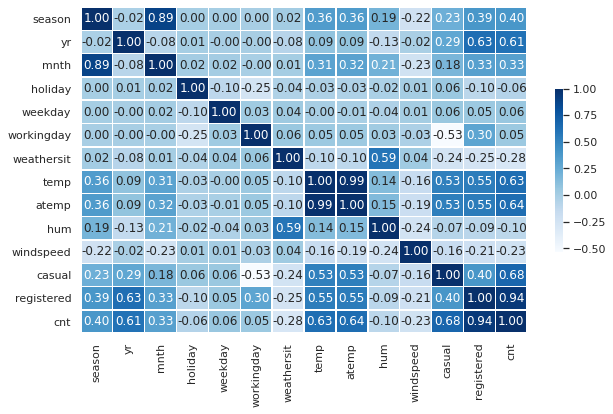

In [15]:
# look at correlations of features
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(),  cmap='Blues', annot=True,
            fmt=".2f", square=False, linewidths=.5, cbar_kws={"shrink": .5})

We can observe that some of our features are highly correlated.
- temp and atemp are almost perfectly correlated, as expected
- casual, registered and cnt are highly correlated. These will also not be useful in prediction, since it would introduce leakage.
- season and mnth are highly correlated

In [16]:
# drop columns
train.drop(columns=['atemp', 'season'], inplace=True)

I dropped a few columns here:
- atemp, as this is highly correlated with temp
- season, as this is explained with the month variable

In [17]:
train.head()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,2011-01-01,0,1,0,6,0,2,0.34,0.81,0.16,331,654,985
1,2011-01-02,0,1,0,0,0,2,0.36,0.70,0.25,131,670,801
2,2011-01-03,0,1,0,1,1,1,0.20,0.44,0.25,120,1229,1349
3,2011-01-04,0,1,0,2,1,1,0.20,0.59,0.16,108,1454,1562
4,2011-01-05,0,1,0,3,1,1,0.23,0.44,0.19,82,1518,1600


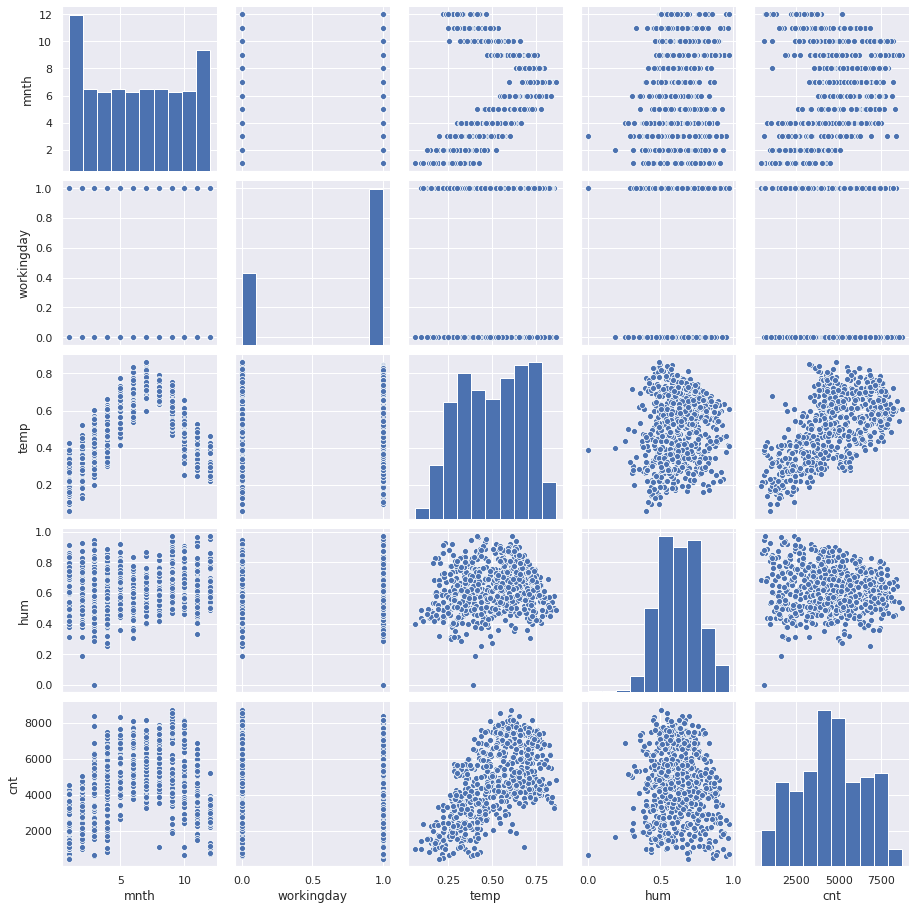

In [18]:
# look at relationships between some of the columns
sns.pairplot(train[['mnth', 'workingday', 'temp', 'hum', 'cnt']])

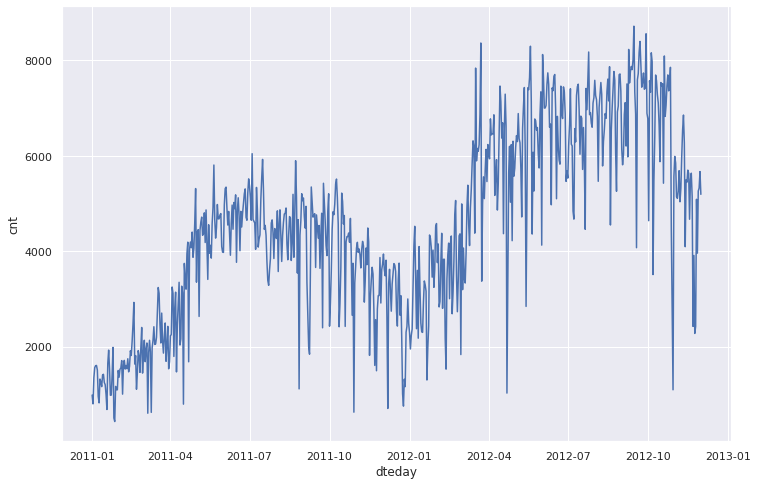

In [19]:
# visualize rentals of bikes per day
plt.figure(figsize=(12,8))
ax = sns.lineplot(train['dteday'], train['cnt'])
plt.show()

We can see from the above plot that this data contains perodicity; that is, rentals appear to increase during the warmer summer months. It also appears there is some upward trend, as 2012 volumes are higher than 2011.

In [20]:
# using assumption provided above, estimate the estiamted bikes needed per day. round these values up.
train['num_bikes'] = train['cnt'].apply(lambda cnt: math.ceil(cnt/12))

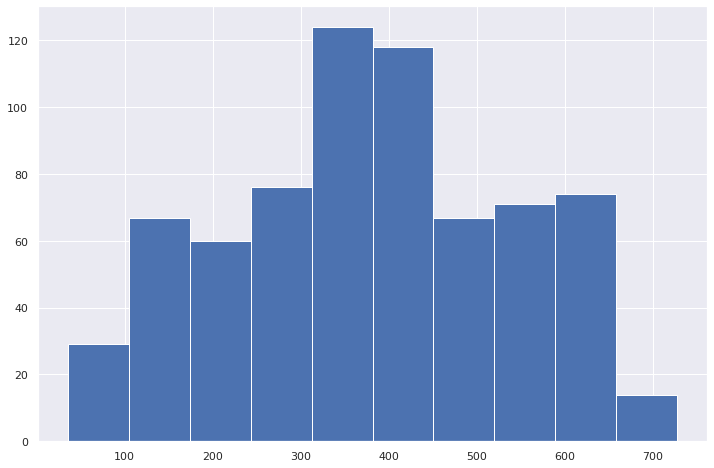

In [21]:
# visualize this distribution
plt.figure(figsize=(12,8))
train['num_bikes'].hist()
plt.show()

In [22]:
# find max bikes needed
nmax = train['num_bikes'].max()

nmax

727

In [23]:
# find 95th percentile
n95 = math.ceil(train['num_bikes'].quantile(.95))
n95

633

In [24]:
# aggregate data to look at percent of days covered vs number of bikes
percent_covered = pd.DataFrame(columns=['num_bikes', 'pct_cover'])

for index, num_bikes in enumerate(train['num_bikes'].sort_values().unique()):
    percent_covered.loc[index] = [num_bikes, len(train[train['num_bikes'] <= num_bikes])/len(train)]

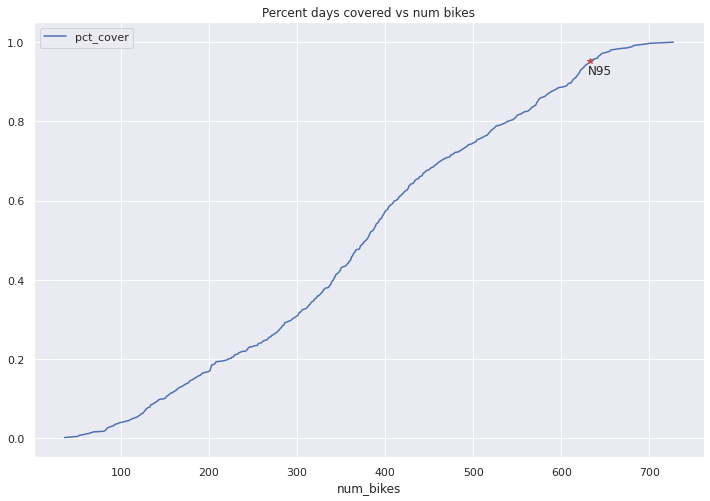

<Figure size 432x288 with 0 Axes>

In [25]:
# plot this data
percent_covered.plot(x='num_bikes',
                     y='pct_cover',
                     figsize=(12,8),
                     title='Percent days covered vs num bikes')
plt.plot(633, 0.953, 'ro', marker='*') 
plt.annotate('N95', (630, 0.92))
plt.figure()
plt.show()

**Answers / comments / reasoning:**

In this section, I explored the data a bit, removed a single outlier and calculated nmax and n95:
- nmax = 727
- n95 = 633

I finished off with a plot to show the number of days covered based on the number of bikes available.

## Part 3 - Building prediction models

**Tasks:**
1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.
2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn. 
3. Report the value of the chosen test metric on the provided data. 

In [26]:
train.columns

Index(['dteday', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt',
       'num_bikes'],
      dtype='object')

In [27]:
# determine features to use for the model, split into X,y sets
features = [
            'yr',
            'mnth',
            'holiday',
            'weekday',
            'workingday',
            'weathersit',
            'temp',
            'hum',
            'windspeed']

X = train[features]
y = train['cnt']

In order to estimate required supply, I will model the expected *cnt*, therefore this will be the target variable in my models. I have also included all of the features which we have to work with. Below, I define two functions containing baseline models: random forest and XGBoost.

In [28]:
# fit baseline random forest model

def baseline_cv_regressor(X, y, splits=3, repeats=5):
    
    model = RandomForestRegressor()
        
    rkf = RepeatedKFold(n_splits=splits,
                        n_repeats=repeats)
    
    r2 = []
    mape = []
    
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # log error metrics
        r2.append(r2_score(y_test, y_pred))
        mape.append(np.mean(np.abs(y_test - y_pred)/y_test))
        

    print(f'Error metrics across {splits} splits and {repeats} repeats.')
    print(f'MAPE: {round(np.mean(mape), 2)}, R2: {round(np.mean(r2), 3)}')
    
    return model

In [72]:
# check error metrics for RF regressor
regressor = baseline_cv_regressor(X,y)

Error metrics across 3 splits and 5 repeats.
MAPE: 0.16, R2: 0.872


In [30]:
# fit baseline XGB regressor

def baseline_cv_xgb(X, y, splits=3, repeats=5):
    
    model = xgb.XGBRegressor()
        
    rkf = RepeatedKFold(n_splits=splits,
                        n_repeats=repeats)
    
    r2 = []
    mape = []
    residuals = [] # added for part 5
    
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        residuals += list(y_test - y_pred)

        # log error metrics
        r2.append(r2_score(y_test, y_pred))
        mape.append(np.mean(np.abs(y_test - y_pred)/y_test))

    print(f'Error metrics across {splits} splits and {repeats} repeats.')
    print(f'MAPE: {round(np.mean(mape), 2)}, R2: {round(np.mean(r2), 3)}')
    
    return model, residuals
    

In [65]:
# check error metrics for XGB regressor
# residuals added for part 5
xgb_regressor, residuals = baseline_cv_xgb(X,y)

Error metrics across 3 splits and 5 repeats.
MAPE: 0.16, R2: 0.865


These functions use RepeatedKFold, which takes random samples and repeats the Kfold process a number of times. The output from the baseline model yields error metrics and a fit model. We can see that both models perform similarly before tuning. Note: since I'm using RepeatedKFold, these numbers will change slightly each time.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


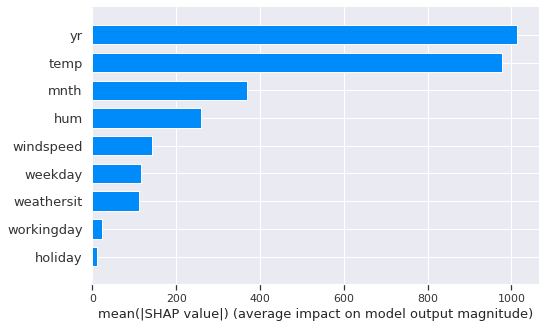

In [32]:
# look at feature importance using SHAP

explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

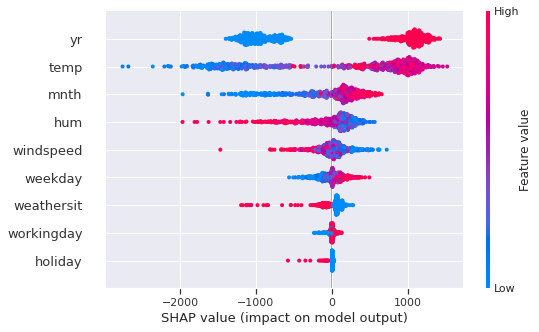

In [33]:
# look at feature impact on model

shap.summary_plot(shap_values, X)

From the above plots, we can see the importance of each feature on the model. It is obvious that year and temp are the most important, but most other features add value as well. The _holiday_ column isn't very important, but does add some incremental value to the model. For this reason, I will not trim any features, since our feature set is already quite limited.

The second plot shows how the value of each independent value impacts the output prediction. For example, as temp increases (red), there is a positive output on the model, which is intuitive.

**Answers / comments / reasoning:**

In this section, I built two models to compare against one another, both of which are ensemble models: random forest and gradient boosted trees. I used both baseline models to predict the daily demand (cnt). I assessed the quality of each model using RepeatedKFold and the r2 metric.

The outcome was similar between the two of them, with the r2 value around 0.87 for both. Below, I will fine-tune the XGBoost model, as the boosted model is likely to perform better than the random forest once the hyperparameters are tuned.

## Part 4 - Fine-tuning of one of the models

**Tasks:**
1. Take one of the above constructed models and finetune its most important hyperparameters
2. Explain your choice for the hyperparameters
3. Report the improvement of your test metric

In [34]:
#define parameter grid - will iteratively update to fine-tune model
grid = {'max_depth': [2, 4, 6, 8, 10],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [100, 250, 500]}

I have chosen to tune the above hyperparameters for the following reasons:
- __max depth:__ each further split allows the model to find relations between the previous split and the new variable. Tree-based models often perform better as they go deeper, but risk overfitting.
- __learning rate:__ to avoid potentially missing the global minimum in the gradient descent, I test a few values here. We need to find the optimal rate to get minimize the cost function as quickly as possible.
- __n_estimators:__ generally, boosted trees perform better with more rounds, as each following tree is fit on the errors from the previous. This can cause overfitting if the number of estimators is too high.

Using GridSearchCV, I'm able to find the optimal parameters without overfitting the model.

In [35]:
# extend above xgb_regressor function to include grid search for tuning

def optimized_cv_regressor(X, y, grid):

    model = xgb.XGBRegressor()


    grid_search = GridSearchCV(estimator=model,
                               param_grid=grid,
                               scoring='r2',
                               cv=RepeatedKFold(n_splits=3, n_repeats=5),
                               verbose=2,
                               n_jobs=-1)

    grid_search.fit(X, y)

    optimized_parameters = grid_search.best_params_
    best_score = grid_search.best_score_
    model = grid_search.best_estimator_

    preds = model.predict(X)


    return {'parameters':optimized_parameters,
            'best_score':best_score,
            'model':model}

In [36]:
opt_regressor = optimized_cv_regressor(X, y, grid)

Fitting 15 folds for each of 30 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   55.5s finished


In [37]:
# now that we have found the optimum parameters, let's check the r2 score
opt_regressor['best_score']

0.8829591295742999

In [38]:
# show best hyperparameters
opt_regressor['parameters']

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}

**Answers / comments / reasoning:**

Using GridSearchCV, I fine-tuned a few of the hyperparameters for the XGBoost model. We can see from above that this improved our R2 metric to 88%, which is only a small increase. This value may be able to be improve further with additional feature engineering and model tuning.

## Part 5 - Optimise (revenue - cost) by adapting number of bicycles
**Tasks:**
1. Assume that the revenue per rental is x (your own assumed number).
2. Each bicycle has costs of y per day (your own assumed number).
3. Determine residuals from your test set (after predicting demand of bike sharing). Consider the residuals as random shocks affecting the average values and resulting in real observed values. Assume this random variable is gaussian distributed. Calculate mean and standard deviation and use it as approximation for a gaussian distribution where you can sample from.
4. Simulate the profit with a fixed number of `nmax` (from part 2) bicycles for the next 30 days given that the real observed values are expected to be different from average predicted values. Calculate the demand by adding the simulated residuals to calculated expected values from the data you put aside in part 1.
5. Use grid search along the number of available bikes to find the optimal number of bikes to obtain highest profit (revenue - cost) from simulations.


In [39]:
# find share of rentals that were registered
total_reg = train['registered'].sum()
total = train['cnt'].sum()
print(f'Of all {total} rentals, {total_reg} were from registered users. This represents {round(100 *total_reg/total, 2)}%.')

Of all 3174135 rentals, 2566414 were from registered users. This represents 80.85%.


In [40]:
# calculate (see notes below)
registered_rev_per_rental = ((85/(12*20)) * .8) + (((85/(12*20))+ 1.5) * .2) 

In [41]:
# registered rev/rental
registered_rev_per_rental

0.6541666666666668

In [42]:
# assumed guest-user rev/rental
non_registered_rev_per_rental = 1.5

In [43]:
# add assumptions for revenue/cost
rev_rental = (.8085 * .6541) + ((1-.8085)*non_registered_rev_per_rental)
cost_day = 1200/1095

In [44]:
# show cost per day (notes below)
cost_day

1.095890410958904

In [45]:
# show revenue per rental
rev_rental

0.81608985

Revenue and cost per rental were estimated as follows:
- Using the data set, I looked at the average share of users which were registered. I will make the assumption that all of these users have annual passes, which cost 85usd/year. I will also assume that these users commute 20 days a month (4 x 5) and generally use the bikes for 30 minutes, which is included in the membership. Surely, there will be some cases which they use the bike for longer, so I will assume that 20% of the time, they incur a 1.50usd charge for a 30-59 minute ride.

- For the other users who were not registered, I will assume these customer used single-use passes each time, which is 1usd for the first 30 minutes, 3usd for 30-59 minutes and 4usd for 60-89 minutes. I will assume the average cost incurred for these rentals is 1.5usd.

- Based on some estimates I found online, a bike with docking station can cost as much as 5700usd, but a bike alone costs around 1200usd. Let's assume for the purpose of this exercise that we have docking stations already, but need to determine the optimal number of bikes only. We'll also assume the lifespan of a bike is 3 years (1095 days). I will assume the cost per day is 1200/1095.

(https://www.washingtonpost.com/news/dr-gridlock/wp/2015/08/05/a-3-5-million-capital-bikeshare-bike-purchase-explained/)

In [46]:
# add num_bikes to held out set
test['num_bikes_actual'] = test['cnt'].apply(lambda cnt: math.ceil(cnt/12))

In [47]:
# add predictions to our held out data set from part 1
test['y_pred'] = opt_regressor['model'].predict(test[features])

As I used cross validation instead of a train/test split, I modified my function for the baseline XGBoost classifer to log residuals at each fold of the CV process. I will use the output of this for the next section.

In [48]:
# calculate residual mean and std
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
print(f'Residual mean: {mean_residual}, std: {std_residual}.')

Residual mean: -4.708359200613839, std: 721.1015719604492.


<AxesSubplot:>

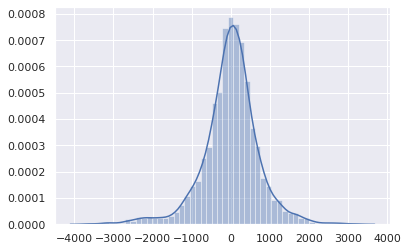

In [49]:
# look at distribution of these residuals
sns.distplot(residuals)

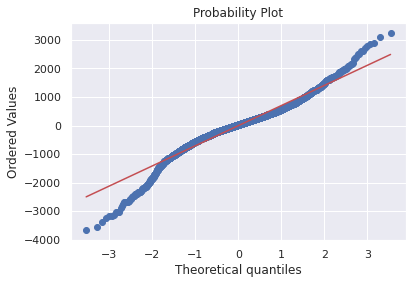

In [50]:
# check to see how "normal" this distribution is
stats.probplot(residuals, dist="norm", plot=sns.mpl.pyplot)
plt.show()

Since I used repeated CV to generate this list of residuals, the number of samples is already quite large and the distribution is approaching normal, centered around 0 as expected. However, for this exercise, I will simply use the mean and std deviation to sample from a true normal distribution.

In [52]:
# estimate demand by adding sample from normal distribution to expected value
test['est_demand'] = test['y_pred'].apply(lambda x: x + int(np.random.normal(mean_residual, std_residual, 1)))

In [53]:
# convert the estimated demand to number of bikes
test['num_bikes_est'] = test['est_demand'].apply(lambda cnt: math.ceil(cnt/12))

In [54]:
test.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,num_bikes_actual,y_pred,est_demand,num_bikes_est
701,2012-12-02,4,1,12,0,0,0,2,0.35,0.36,0.82,0.12,892,3757,4649,388,"3,988.99","4,900.99",409
702,2012-12-03,4,1,12,0,1,1,1,0.45,0.46,0.77,0.08,555,5679,6234,520,"6,182.36","6,777.36",565
703,2012-12-04,4,1,12,0,2,1,1,0.48,0.47,0.73,0.17,551,6055,6606,551,"6,349.36","7,075.36",590
704,2012-12-05,4,1,12,0,3,1,1,0.44,0.43,0.48,0.32,331,5398,5729,478,"6,328.93","5,751.93",480
705,2012-12-06,4,1,12,0,4,1,1,0.26,0.26,0.51,0.17,340,5035,5375,448,"4,261.94","4,628.94",386


In [55]:
# calculate profit with nmax bikes 
test['nmax_profit'] = (test['num_bikes_est'] * rev_rental * 12) - (cost_day * nmax)

In [56]:
test.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,num_bikes_actual,y_pred,est_demand,num_bikes_est,nmax_profit
701,2012-12-02,4,1,12,0,0,0,2,0.35,0.36,0.82,0.12,892,3757,4649,388,"3,988.99","4,900.99",409,"3,208.66"
702,2012-12-03,4,1,12,0,1,1,1,0.45,0.46,0.77,0.08,555,5679,6234,520,"6,182.36","6,777.36",565,"4,736.38"
703,2012-12-04,4,1,12,0,2,1,1,0.48,0.47,0.73,0.17,551,6055,6606,551,"6,349.36","7,075.36",590,"4,981.20"
704,2012-12-05,4,1,12,0,3,1,1,0.44,0.43,0.48,0.32,331,5398,5729,478,"6,328.93","5,751.93",480,"3,903.97"
705,2012-12-06,4,1,12,0,4,1,1,0.26,0.26,0.51,0.17,340,5035,5375,448,"4,261.94","4,628.94",386,"2,983.42"


In [57]:
# with nmax bikes in place, our estimated profit
test['nmax_profit'].sum()

82588.56248378629

As you can see, our estimated profit with nmax bikes available is around 82000*. By optimizing the number of bikes, we may be able to improve this number.

*note: this number can change as new predictions are made.

In [58]:
# define "grid" to test optimal number of bikes
num_bike_grid = np.arange(100,1010, 10)

In [59]:
# loop through the bike grid above and calculate the profit at each quantity of bikes
bikes = []
profits = []

for est in num_bike_grid:
    bikes.append(est)
    test['optimal_bikes'] = est
    profits.append(int(sum((test[['num_bikes_est','optimal_bikes']].min(axis=1) * rev_rental * 12) - (cost_day * est))))

In [76]:
# get index of max profit
max_profit_index = max(range(len(profits)), key=profits.__getitem__)

In [77]:
# using index from max profits, get optimal number of bikes
opt_bikes = bikes[max_profit_index]

In [78]:
# using index from max profits, get max profit
max_profit = profits[max_profit_index]

Text(490, 86637, 'n_opt')

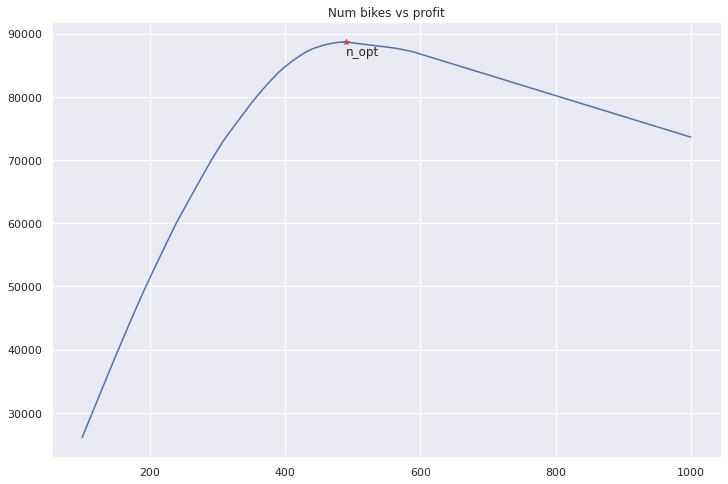

In [82]:
# plot bike profit curve
plt.figure(figsize=(12,8))
ax = sns.lineplot(x=bikes,
                  y=profits)
ax.set_title('Num bikes vs profit')
plt.plot(opt_bikes, max_profit, 'ro', marker='*') 
plt.annotate('n_opt', (opt_bikes, max_profit-2000))

**Answers / comments / reasoning:**

I started this section with some estimates for revenue based on heuristics and a bit of research done on the bike-provider's website. I estimated demand by predicting expected values from the opimized model and added sampled residuals from part 4 to these. Using these estimates, I then calculated the estimated profit per day at nmax, then found the optimal number of bikes needed to maximize profits.

From my analysis, the optimal number of bikes (n_opt) to maximize revenue given the one month of data that we have to test, is 490 (+/-). By offering this number of bikes, we can expect an increase in monthly profits from 82000 to 88000 or 7% compared to using nmax bikes. This will vary slightly with each run of the model.

## Part 6 - Reflection / comments

**Tasks:**
(Optional) Please share with us any free form reflection, comments or feedback you have in the context of this test task.

I found this task quite enjoyable and an engaging shift from the standard tasks for interviews. The regression model part was as expected, but the profit simulation was a nice addition that makes the candidate think further of the business implications of the problem at hand, which I find key in application of machine learning.

A few points of feedback:
- Consider using a larger data set, since the daily bike demand one is quite small.
- Consider using a messier data set which requires feature engineering to extract value for the model. This data set was more or less ready for prediction, which is not the case in real-world applications.
- I found the instructions a bit confusing at times, namely in part 5. There is reference to a "test" data set, which I assumed was the 30 days that we held out in part 1, but I believe this referred to a test set split off from the larger dataset in the modelling section. I ended up modifying my cross-validation model functions in order to simulate the residuals which would come from a test set if I had one.

## Submission

Please submit this notebook with your developments in .ipynb and .html formats as well as your requirements.txt file.

## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 